<a href="https://colab.research.google.com/github/fizzyf0xy/NLP/blob/main/Word2Vec_skipgram_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Word2Vec

In [87]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [88]:
np.__version__, torch.__version__

('1.22.4', '1.13.1+cu116')

In [89]:
import matplotlib
matplotlib.__version__

'3.5.3'

##1. Load the data

In [90]:
#specify the sentences / corpus
#corpus is defined as a set of documents
#document is basically a bunch of sentence(s)
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple", 
          "dog cat animal", "cat dog animal", "cat animal dog"]

In [91]:
#1. tokenize
#usually you use spaCy / NLTK to tokenize (but we gonna do this later on, we gonna have spaCy)
corpus_tokenized = [sent.split(" ") for sent in corpus]
corpus_tokenized  #we called each of this as "tokens", NOT words

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'dog', 'animal'],
 ['cat', 'animal', 'dog']]

In [92]:
#2. numericalize

#2.1 get all the unique words
#we want to flatten this (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))  #vocabs is a term defining all unique words your system know

In [93]:
corpus2 = ["river mountain nature", "mountain river nature", "mountain fountain river",
           "fox rabbit animal", "rabbit fox animal", "rabbit animal fox"]

In [94]:
corpus2_tokenized = [sent.split(" ") for sent in corpus2]
corpus2_tokenized


[['river', 'mountain', 'nature'],
 ['mountain', 'river', 'nature'],
 ['mountain', 'fountain', 'river'],
 ['fox', 'rabbit', 'animal'],
 ['rabbit', 'fox', 'animal'],
 ['rabbit', 'animal', 'fox']]

In [95]:
# try 2. numericalize
#2.1 get all the unique words
#we want to flatten this (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs2  = list(set(flatten(corpus2_tokenized)))  #vocabs is a term defining all unique words your system know

In [96]:
#2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}

In [97]:
word2index

{'dog': 0, 'animal': 1, 'apple': 2, 'fruit': 3, 'banana': 4, 'cat': 5}

In [98]:
word2index['apple']

2

In [99]:
word2index2 = {v: idx for idx, v in enumerate(vocabs2)}

In [100]:
word2index2['nature']

3

In [101]:
#add <UNK>, which is a very normal token exists in the world
vocabs.append('<UNK>') #chaky, can it be ##UNK, or UNKKKKKK, or anything

In [102]:
vocabs2.append('<UNK>')

In [103]:
#now we have a way to know what is the id of <UNK>
word2index['<UNK>'] = 6  #usually <UNK> is 0

In [104]:
word2index2['<UNK>'] = 7

In [105]:
#create index2word dictionary
#2 min    
index2word = {v:k for k, v in word2index.items()}

index2word

{0: 'dog',
 1: 'animal',
 2: 'apple',
 3: 'fruit',
 4: 'banana',
 5: 'cat',
 6: '<UNK>'}

In [106]:
index2word2 = {v:k for k, v in word2index2.items()}
index2word2

{0: 'fountain',
 1: 'mountain',
 2: 'animal',
 3: 'nature',
 4: 'fox',
 5: 'rabbit',
 6: 'river',
 7: '<UNK>'}

In [107]:
vocabs

['dog', 'animal', 'apple', 'fruit', 'banana', 'cat', '<UNK>']

In [108]:
vocabs2

['fountain', 'mountain', 'animal', 'nature', 'fox', 'rabbit', 'river', '<UNK>']

## 2. Prepare train data

In [109]:
#move along the corpus
#to fit with our corpus, we gonna use window_size = 1

skipgrams = []

#for each corpus
for sent in corpus_tokenized:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(1, len(sent) - 1): #start from 1 to second last
        center_word = sent[i]
        outside_words = [sent[i-1], sent[i+1]]  #window_size = 1
        for o in outside_words:
            skipgrams.append([center_word, o])

skipgrams
        
#here we want to create (banana, apple), (banana, fruit) append to some list

[['banana', 'apple'],
 ['banana', 'fruit'],
 ['apple', 'banana'],
 ['apple', 'fruit'],
 ['fruit', 'banana'],
 ['fruit', 'apple'],
 ['cat', 'dog'],
 ['cat', 'animal'],
 ['dog', 'cat'],
 ['dog', 'animal'],
 ['animal', 'cat'],
 ['animal', 'dog']]

In [110]:
# #move along the corpus
# #to fit with our corpus, we gonna use window_size = 1

# skipgrams = []

# #for each corpus
# for sent in corpus2_tokenized:
#     #for each sent ["apple", "banana", "fruit"]
#     for i in range(1, len(sent) - 1): #start from 1 to second last
#         center_word = sent[i]
#         outside_words = [sent[i-1], sent[i+1]]  #window_size = 1
#         for o in outside_words:
#             skipgrams.append([center_word, o])

# skipgrams
        
# #here we want to create (banana, apple), (banana, fruit) append to some list

In [111]:
#let's make what we have made into a function (batch function)
#return a batches of data, e.g., =2 --> ['banana', 'apple'], ['banana', 'fruit']
#also i want these batches to be id, NOT token   --> [5, 4]

def random_batch(batch_size, corpus):
    
    skipgrams = []

    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ["apple", "banana", "fruit"]
        for i in range(1, len(sent) - 1): #start from 1 to second last
            center_word = word2index[sent[i]]
            outside_words = [word2index[sent[i-1]], word2index[sent[i+1]]]  #window_size = 1
            for o in outside_words:
                skipgrams.append([center_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)
    

In [112]:

# def random_batch(batch_size,corpus):

#   skipgram = []

#   #for each corpus

#   for sent in corpus2_tokenized:
#         #for each sent ["apple", "banana", "fruit"]
#         for i in range(1, len(sent) - 1): #start from 1 to second last
#             center_word = word2index2[sent[i]]
#             outside_words = [word2index2[sent[i-1]], word2index2[sent[i+1]]]  #window_size = 1
#             for o in outside_words:
#                 skipgrams.append([center_word, o])
                
#     #only get a batch, not the entire list
    
#   random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
#     #appending some list of inputs and labels

#   random_inputs, random_labels = [], []   
  
#   for index in random_index:
#         random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
#         random_labels.append([skipgrams[index][1]])
#   return np.array(random_inputs), np.array(random_labels)



In [113]:
input, label = random_batch(10, corpus_tokenized)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[4],
       [5],
       [2],
       [1],
       [1],
       [3],
       [4],
       [0],
       [3],
       [5]])


In [114]:
# # try starting from 2
# def random_batch(batch_size,corpus):

#   skipgram = []

#   #for each corpus

#   for sent in corpus2_tokenized:
#         #for each sent ["apple", "banana", "fruit"]
#         for i in range(2, len(sent) - 2): #start from 1 to second last
#             center_word = word2index2[sent[i]]
#             outside_words = [word2index2[sent[i-2]], word2index2[sent[i+2]]]  #window_size = 1
#             for o in outside_words:
#                 skipgrams.append([center_word, o])
                
#     #only get a batch, not the entire list
    
#   random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
#     #appending some list of inputs and labels

#   random_inputs, random_labels = [], []   
  
#   for index in random_index:
#         random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
#         random_labels.append([skipgrams[index][1]])
#   return np.array(random_inputs), np.array(random_labels)

In [115]:
input, label = random_batch(10, corpus_tokenized)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[0],
       [4],
       [1],
       [1],
       [3],
       [5],
       [0],
       [2],
       [5],
       [3]])


## 3. Model

In [116]:
voc_size = len(vocabs)
voc_size

7

In [117]:
voc_size2 = len(vocabs2)
voc_size2

8

In [118]:
#the model will accept three vectors - u_o, v_c, u_w
#u_o - vector for outside words
#v_c - vector for center word
#u_w - vectors of all vocabs

class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size, 1)
        #all_vocabs: (batch_size, voc_size)
        
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term)  #exp(uo vc)
        #(batch_size, 1)
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        #(batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        #(batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

In [119]:
#preparing all_vocabs

batch_size = 2

def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 7])

In [120]:
voc_size

7

In [121]:
voc_size2

8

In [122]:
input, label = random_batch(batch_size, corpus_tokenized)
input #center word

array([[5],
       [3]])

In [123]:
label

array([[1],
       [2]])

In [124]:
input2, label2 = random_batch(batch_size, corpus2_tokenized)
input2 #center word

array([[2],
       [0]])

In [125]:
label2

array([[3],
       [5]])

In [126]:
voc_size

7

In [127]:
voc_size2

8

In [128]:
emb_size = 2 #usually, this can be 50, 100, or 300
model = Skipgram(voc_size, emb_size)

In [129]:
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)  #LongTensor basically means integer....

In [130]:
#this is different
torch.LongTensor(2)

tensor([3199092244751596066, 7304682900672553504])

In [131]:
torch.LongTensor([2])  #put shape (, 1)

tensor([2])

In [132]:
input_tensor.shape

torch.Size([2, 1])

In [133]:
label_tensor.shape

torch.Size([2, 1])

In [134]:
all_vocabs

tensor([[0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6]])

In [135]:
#this should give one number
loss = model(input_tensor, label_tensor, all_vocabs)

##4. Training

In [136]:
batch_size = 2 #why?  no reason; 
emb_size   = 2 #why?  no reason; usually 50, 100, 300, but 2 so we can plot (50 can also plot, but need PCA)
model      = Skipgram(voc_size, emb_size)

optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [137]:
num_epochs = 5000
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = model
    
    loss = model(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: ??")

Epoch 1000 | Loss: 0.820913 | Time: ??
Epoch 2000 | Loss: 1.048916 | Time: ??
Epoch 3000 | Loss: 0.801917 | Time: ??
Epoch 4000 | Loss: 1.000895 | Time: ??
Epoch 5000 | Loss: 1.616409 | Time: ??


## 5. Plot the embeddings

In [138]:
vocabs

['dog', 'animal', 'apple', 'fruit', 'banana', 'cat', '<UNK>']

In [140]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([4])

In [141]:
banana_center_embed = model.embedding_center_word(banana)
banana_outisde_embed = model.embedding_outside_word(banana)

banana_embed = (banana_center_embed + banana_outisde_embed) / 2
banana_embed

tensor([[4.0533, 2.1779]], grad_fn=<DivBackward0>)

In [142]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

In [143]:
#find embedding of fruit, cat
print(get_embed('fruit'))
print(get_embed('cat'))

print(get_embed('chaky'))

(3.3184046745300293, 4.636585235595703)
(-3.149721622467041, -3.2000458240509033)
(-0.28349125385284424, 0.5217384696006775)


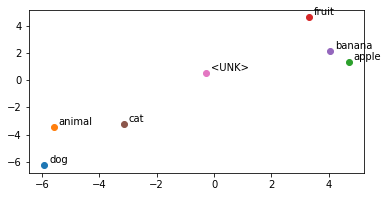

In [144]:
#help me plot fruit cat banana on matplotlib
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()